# Small System of Linear Equations

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

## Orthogonal transformations
Let us test the orthogonal transformations, about which we learn something this morning.
We have $n$ vectors stored in a matrix $A$. 

### Gram-Schmidt orthogonalization

In [2]:
def gram_schmidt(A):
    n = A.shape[0]
    Q = np.eye(n)
    for i in range(n):
        v = A[:, i]
        for j in range(i):
            # Q[:,j] is a unit vector, A[:,j] =v, np.dot = projection
            v = v - np.dot(Q[:, j], A[:, i]) * Q[:, j]
        v = v / np.linalg.norm(v)
        Q[:, i] = v
    return Q

Let's test our function:    

In [3]:
n = 5
A = np.random.random((n, n))

Q = gram_schmidt(A)
error_gs = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_gs)

Q@Q.T == I? True
 The error is  1.4432899320127035e-15


Oh, nice! The error is small enough. So what's the problem?


The functions $${\sin( (k+1)/k\cdot  x)}\qquad k \in {1,\dots, n} $$ are linearly independent. We discretize them on the interval [0, 1] with $x_i = i/n $ for $ i \in {1,\dots, n}$.    

In [4]:
def almost_colinear_matrix(n):
    A = np.zeros((n, n))
    for k in range(n):
        for i in range(n):
            A[k, i] = np.sin((k + 2) * (i + 1) / ((k + 1) * n))
    return A

Let's take a look at these functions:

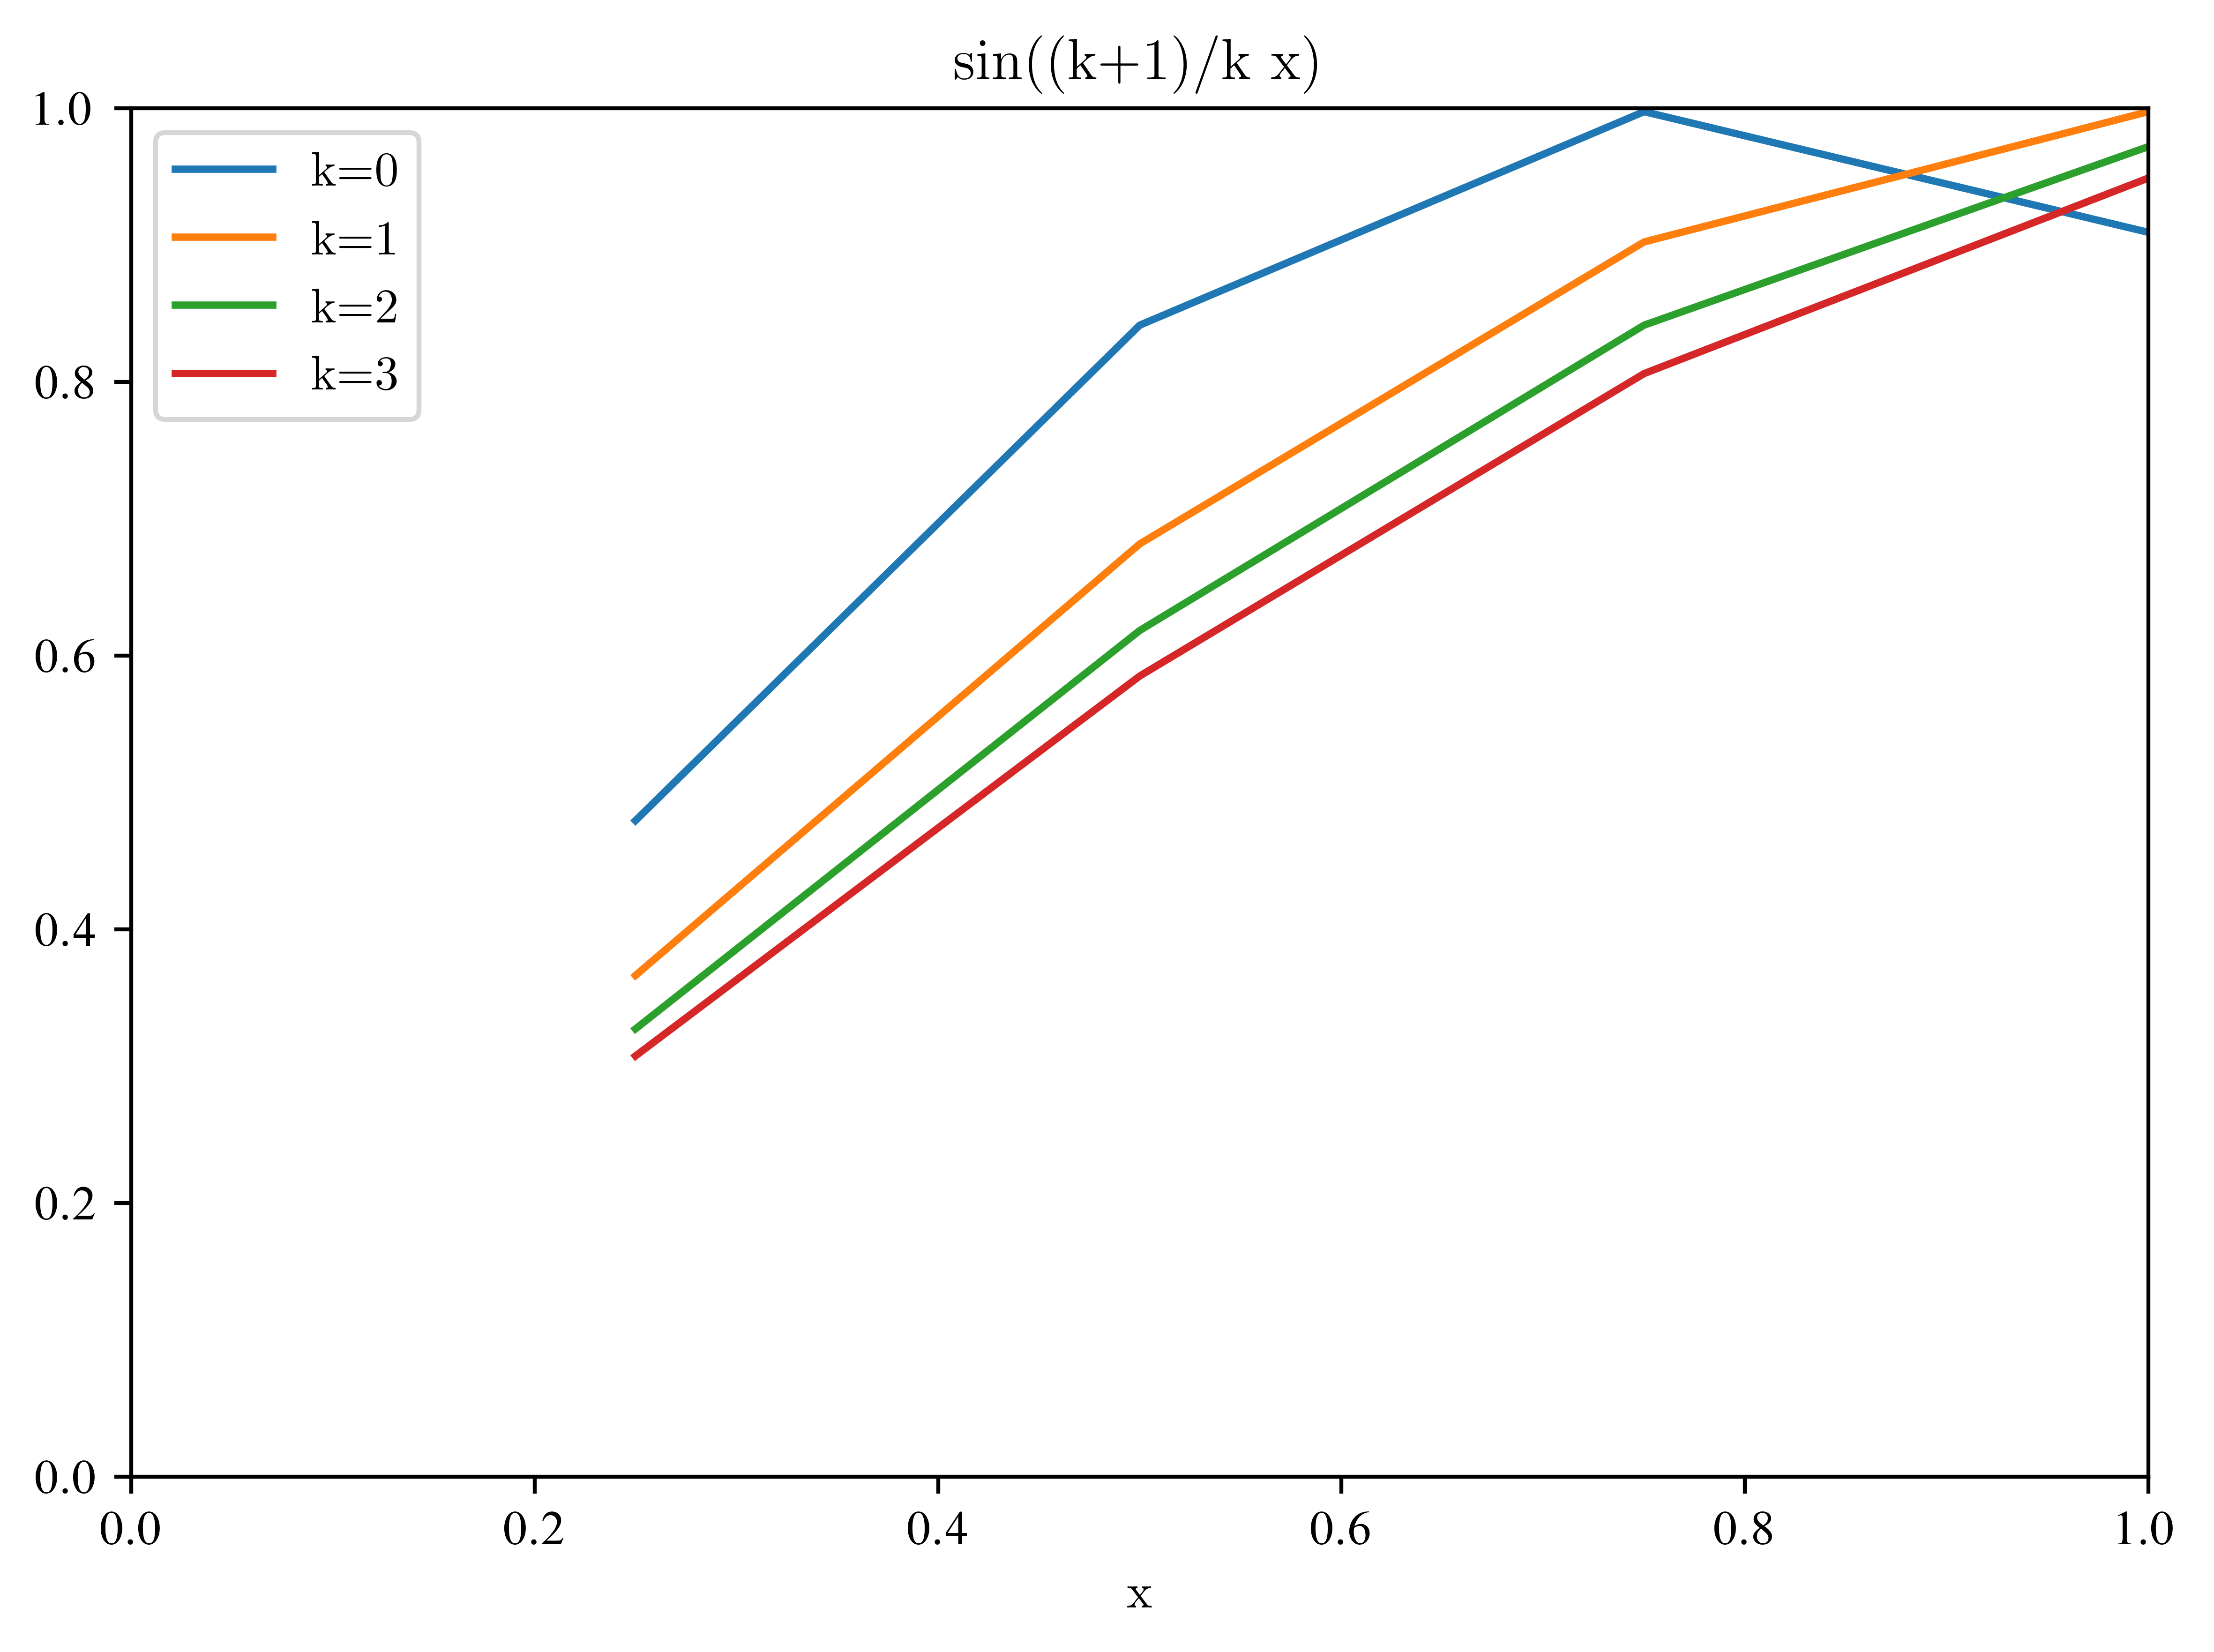

In [5]:
n = 4
x = np.arange(1, n + 1) / n
A = almost_colinear_matrix(n)

for k in range(n):
    plt.plot(x, A[k, :], label="k={}".format(k))
plt.title("sin((k+1)/k x)")
plt.xlabel("x")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

In [6]:
n = 5
A = almost_colinear_matrix(n)

Q = gram_schmidt(A)
error_gs = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_gs)

Q@Q.T == I? False
 The error is  0.38104353388235634


Oh, no! We had only five dimensions...

### Modified Gram-Schmidt


In [7]:
def mod_gram_schmidt(A):
    n = A.shape[0]
    Q = A.copy()
    for i in range(n):
        v = Q[:, i] / np.linalg.norm(Q[:, i])
        Q[:, i] = v
        for j in range(i + 1, n):
            Q[:, j] = Q[:, j] - np.dot(v, Q[:, j]) * v
    return Q

Let's check the implementation: 

In [8]:
n = 5

# first, using a "good" matrix
print("good Matrix:")
A = np.random.random((n, n))

Q = mod_gram_schmidt(A)
error_gs = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_gs)


print("\ncolinear Matrix:")
A = almost_colinear_matrix(n)
Q = mod_gram_schmidt(A)
error_gs = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_gs)

good Matrix:
Q@Q.T == I? True
 The error is  3.9968028886505635e-15

colinear Matrix:
Q@Q.T == I? False
 The error is  7.398328349950134e-08


Nice! It's better than Gram-Schmidt. But larger n, the error increases rapidly (try it out).

In [9]:
def hilbert_matrix(n):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = 1 / (i + j + 1)
    return A

In [10]:
n = 9
A = hilbert_matrix(n)

Q = mod_gram_schmidt(A)
error_gs = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_gs)

Q@Q.T == I? False
 The error is  2.675702741683394e-06


Not what'd like to see, or?

### Householder reflection

In [11]:
def Householder_matrix(v, return_diag_entry=False):
    # Create Matrix Q_v as described above.
    # INPUT: v 1d-array or 2d-array with one column or one row
    # OUPUT: Q Householdermatrix of v

    v = v.copy()  # do not overwrite original matrix
    n = len(v)
    v = v.reshape(
        (n)
    )  # reshape, because tensorprod gives different results for (n) and (n,1) dimension

    if np.linalg.norm(v) == 0:
        return np.eye(n)
    # modify first component
    if v[0] == 0:
        sign = 1
    else:
        sign = v[0] / np.abs(v[0])  # generalized sign, could be complex
    diag_entry = -sign * np.linalg.norm(v)
    v[0] += sign * np.linalg.norm(v)  # linalg.norm calculates the l2 norm of a vector
    v = v / np.linalg.norm(v)
    # calc Q
    Q = np.eye(n) - 2.0 * np.tensordot(
        v, np.conj(v), axes=0
    )  # tensorprod does w w^T multiplication
    if return_diag_entry:
        return Q, diag_entry
    return Q

Now check, if the Householder Matrix has the right properties:
$$Q=Q^*=Q^{-1} $$
and
$$ Qv = \beta e_1$$ 
for some $\beta \in \mathbb{R}$. 

Wonderful!

## QR decomposition


In [12]:
def QR_decomposition(A):
    n = A.shape[0]
    Q = np.eye(n)
    R = A.copy()
    for i in range(min(n, A.shape[1])):
        v = R[i:, i]
        Q_i = Householder_matrix(v)
        R[i:, :] = Q_i @ R[i:, :]
        Q[:, i:] = Q[:, i:] @ Q_i
    return Q, R

A == QR? True


/usr/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


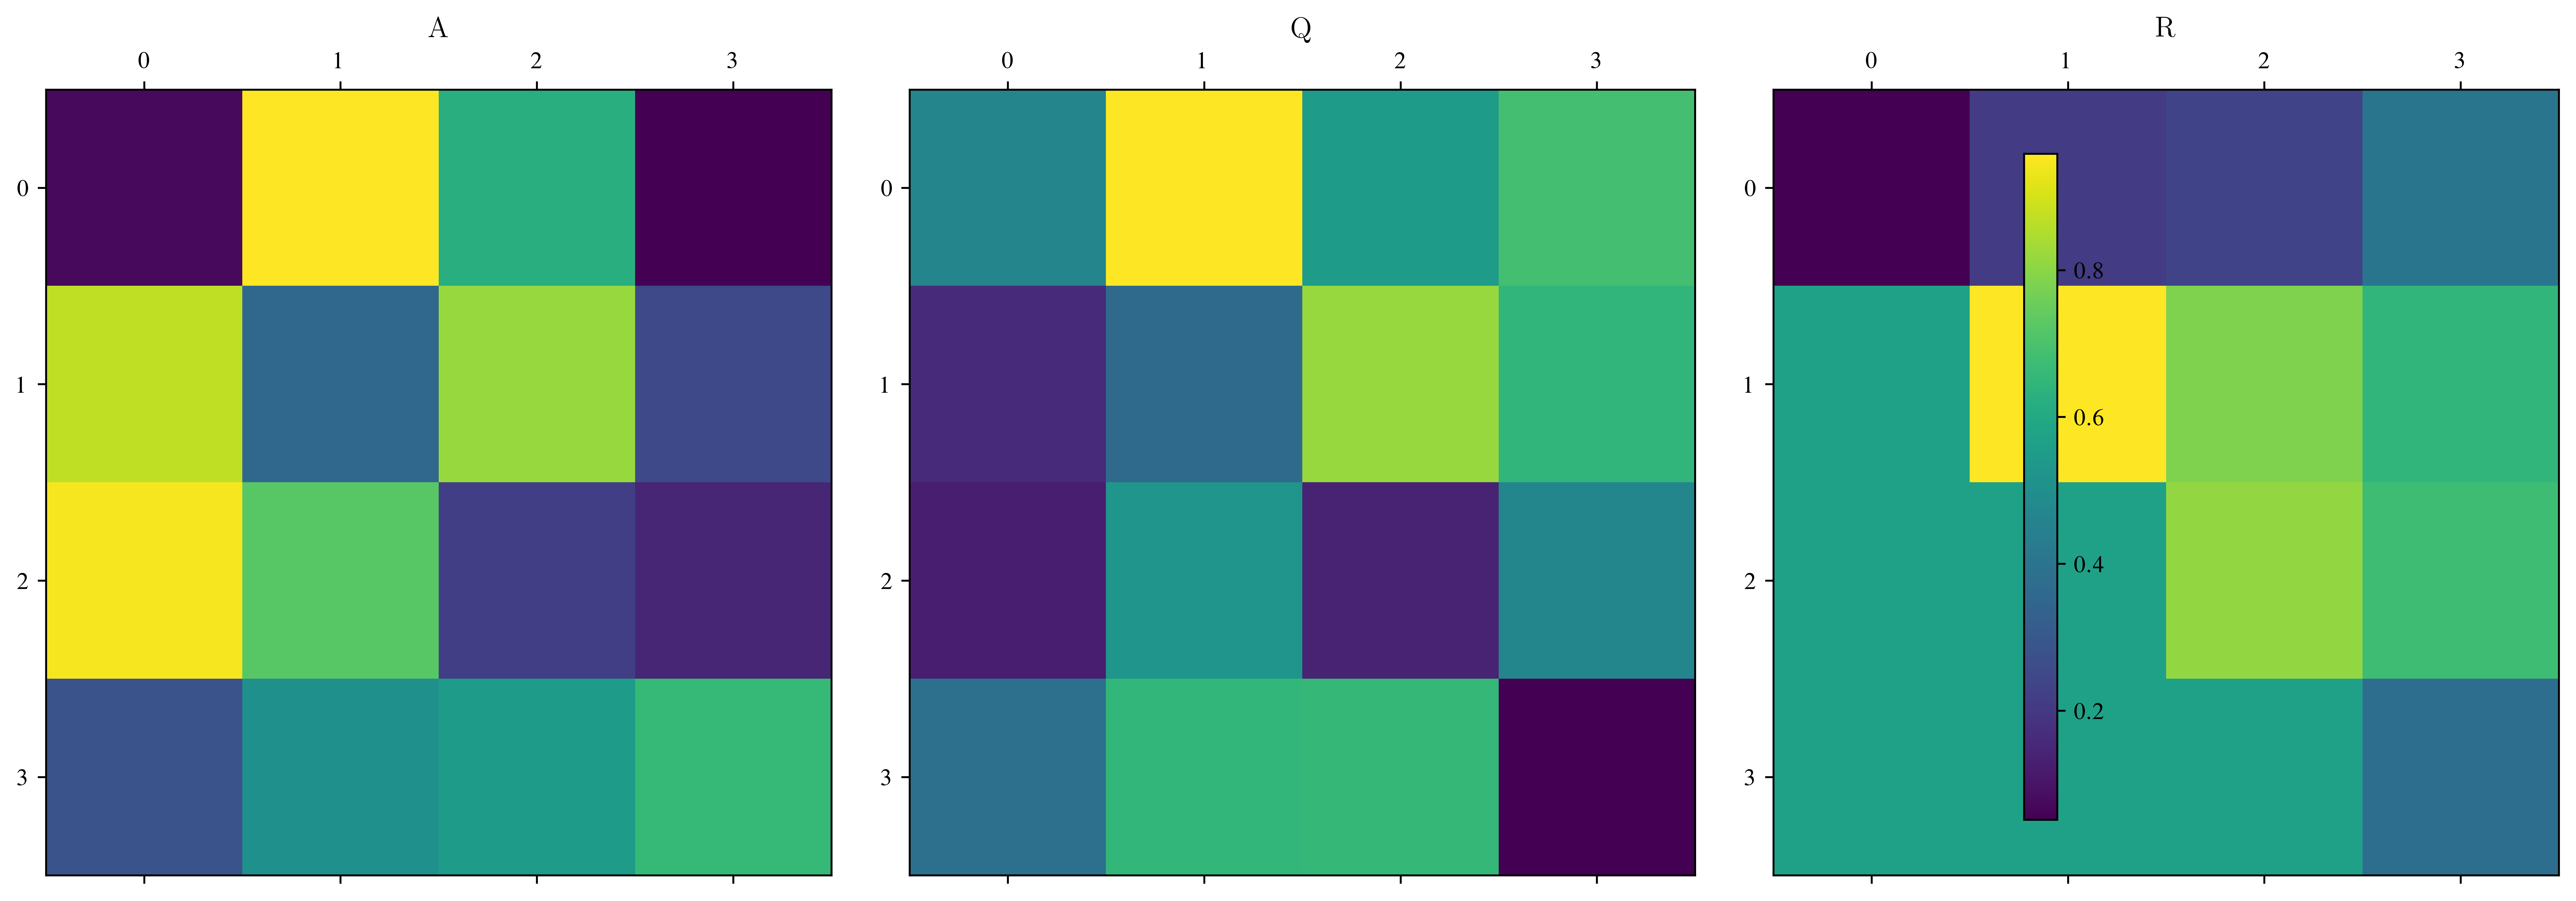

In [13]:
A = np.random.random((4, 4))

Q, R = QR_decomposition(A.copy())
print("A == QR?", np.all(np.abs(A - Q @ R) < 1e-10))
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im = ax[0].matshow(A)
ax[0].set_title("A")
ax[1].matshow(Q)
ax[1].set_title("Q")
ax[2].matshow(R)
ax[2].set_title("R")
fig.colorbar(im, ax=ax)
plt.show()

A == QR? True


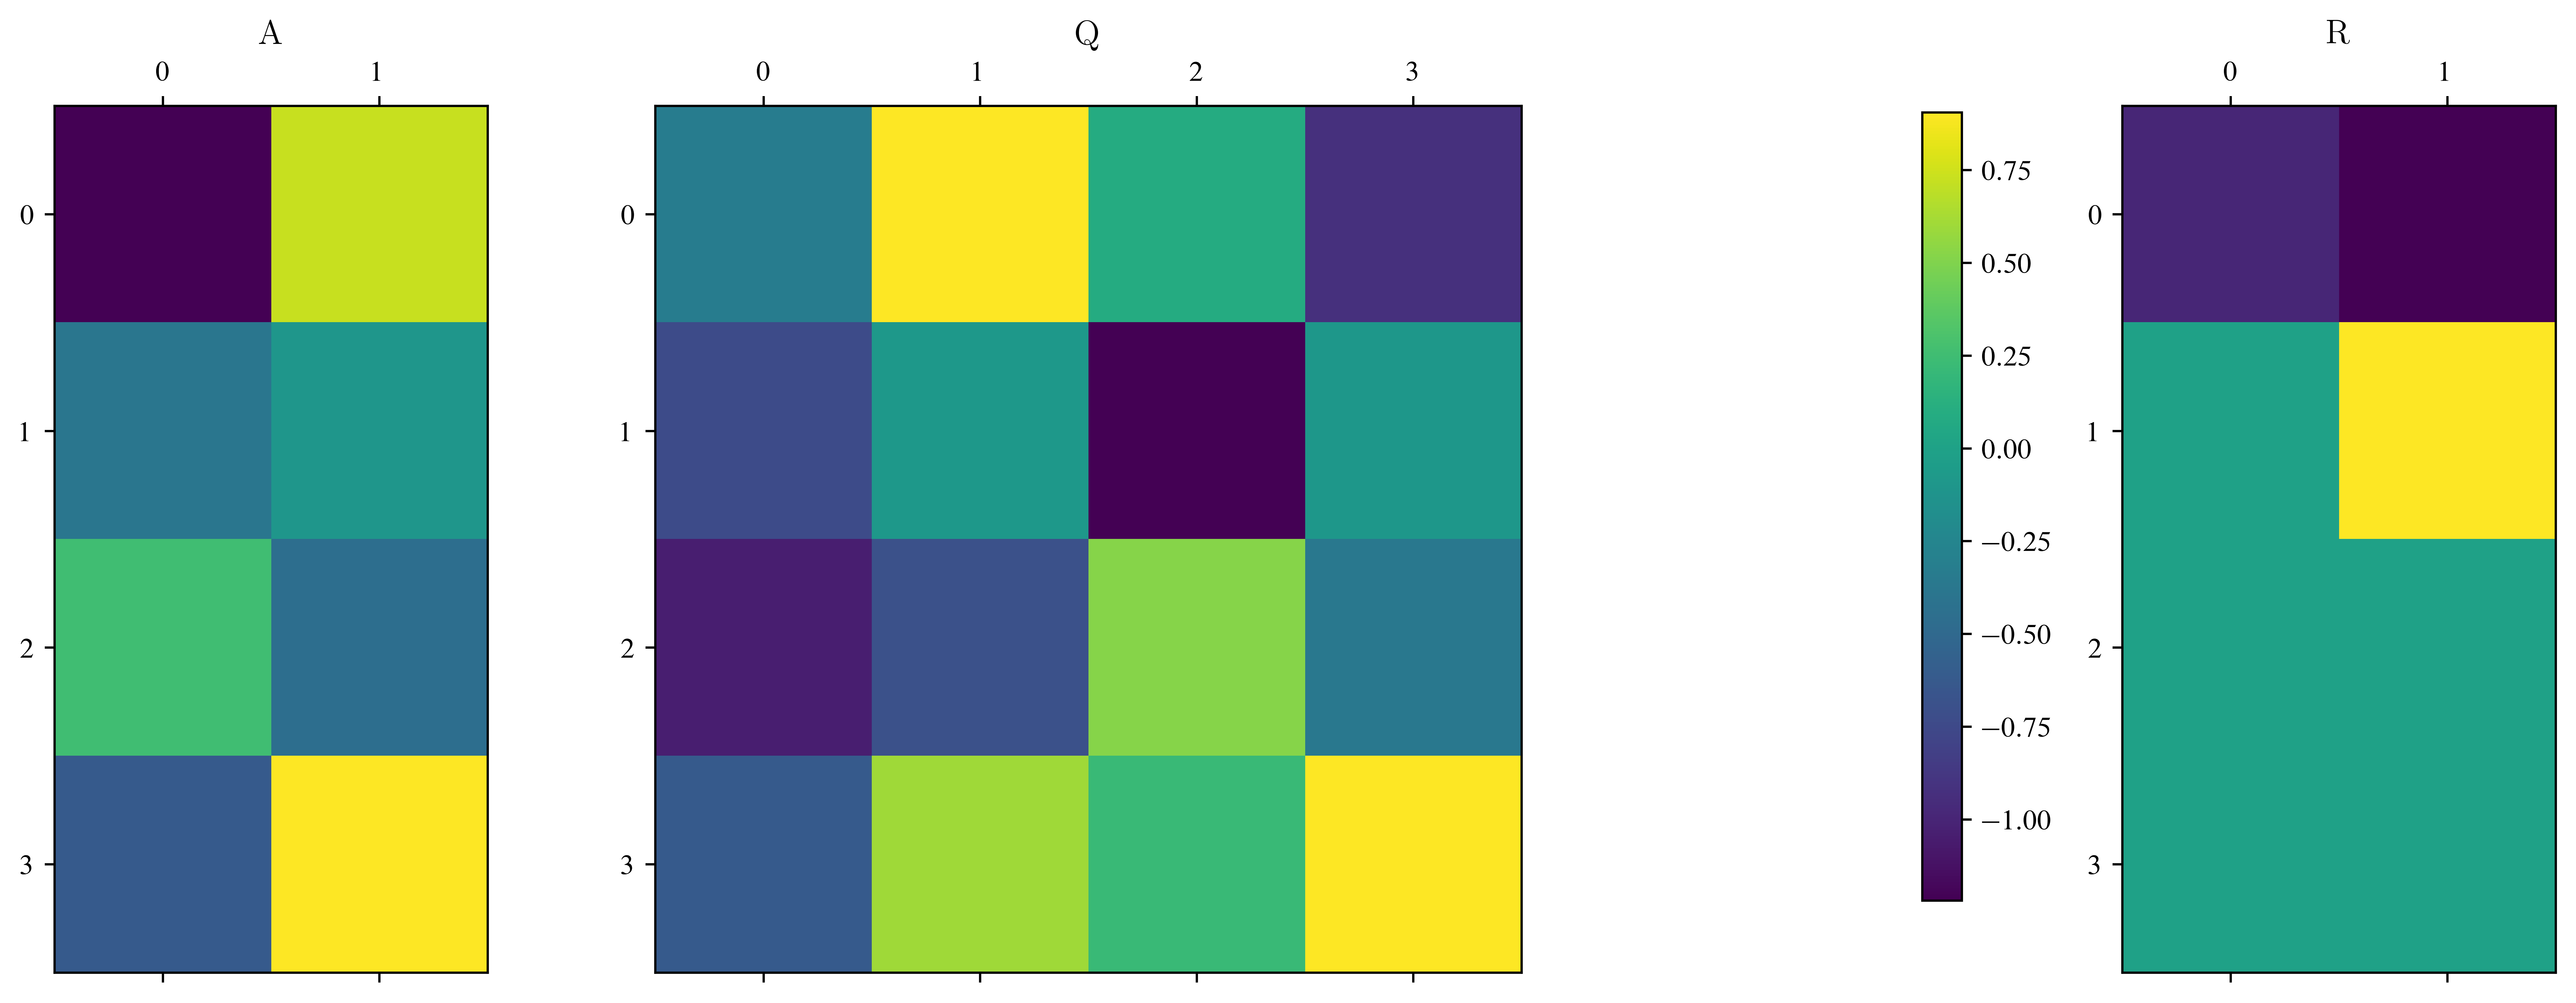

In [14]:
A = np.random.random((4, 2))

Q, R = QR_decomposition(A.copy())
print("A == QR?", np.all(np.abs(A - Q @ R) < 1e-10))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].matshow(A)
ax[0].set_title("A")
ax[1].matshow(Q)
ax[1].set_title("Q")
# the colorbar is only for R important
im = ax[2].matshow(R)
ax[2].set_title("R")
fig.colorbar(im, ax=ax)
plt.show()

Now let's check our "bad guys":

In [15]:
n = 100

print("Random Matrix:")
A = np.random.random((n, n))
Q, R = QR_decomposition(A)
error_hh = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_hh)

print("\ncolinear Matrix:")
A = almost_colinear_matrix(n)
Q, R = QR_decomposition(A)
error_hh = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_hh)

print("\nHilbert Matrix:")
A = hilbert_matrix(n)
Q, R = QR_decomposition(A)
error_hh = np.max(np.abs(Q @ Q.T - np.eye(n)))
print("Q@Q.T == I?", np.all(np.abs(Q @ Q.T - np.eye(n)) < 1e-10))
print(" The error is ", error_hh)

Random Matrix:
Q@Q.T == I? True
 The error is  6.439293542825908e-15

colinear Matrix:
Q@Q.T == I? True
 The error is  6.994405055138486e-15

Hilbert Matrix:
Q@Q.T == I? True
 The error is  5.995204332975845e-15


## Solving linear systems

Let's have a rectangular system:
$$Ax=b$$
Finding the least solution is equivalent to $(A=QR)$
$$ Rx =Q^Tb \qquad \Leftrightarrow  \qquad A^TAx = A^Tb$$

Because $R$ is an upper triangular matrix, we need the backward substitution.

In [16]:
def backward_substitution(U, b):
    n = U.shape[1]
    # This is needed for rectangular R
    if U.shape[0] != n:
        U = U[:n, :n]
        b = b[:n]

    x = np.zeros(n)
    # first step, lower right corner
    x[-1] = b[-1] / U[-1, -1]
    # now backward substitution
    for i in range(n - 2, -1, -1):
        x[i] = (b[i] - U[i, i + 1 :] @ x[i + 1 :]) / U[i, i]
    return x

In [17]:
n = 6
m = 3
A = np.random.random((n, m))
b = np.random.random(n)

# Min via QR
Q, R = QR_decomposition(A)
x_QR = backward_substitution(R, Q.T @ b)

# Min via normal equation
x_normal = np.linalg.solve(A.T @ A, A.T @ b)

# min via optimazation problem:
print("Least Squares Solution:")
from scipy.optimize import minimize


def f(x):
    return np.linalg.norm(A @ x - b)


x_opt = minimize(lambda x: np.linalg.norm(A @ x - b), np.zeros(m)).x

print("normal\t\t", x_normal)
print("QR\t\t", x_QR)
print("optimization\t", x_opt)
print("Residual", np.linalg.norm(A @ x_opt - b))

Least Squares Solution:
normal		 [-0.43445448  0.05306315  1.10622382]
QR		 [-0.43445448  0.05306315  1.10622382]
optimization	 [-0.43445315  0.05306136  1.10622427]
Residual 0.7547178451571135


Now, we can solve rectangular systems:

## Advanced memory management
For large matrices, it's too slow to save Q and R in separate matrices (and store all the Zeros).  
Think about a memory optimized version.
Hints:
1. Do really need Q? Or only the vectors?
2. Which of the entries of the matrix can be overwritten?
3. Which matrices do need for the solution of which problem?

Try to implement some optimizations.


#### Solution
In practice, the matrix Q is never explicitly constructed. Instead,
only the Householder vectors are memorized V = [v1 , . . . , vn ]  which can then be used to apply Q at any time. This not only requires less memory, but is also faster, since applying a matrix Qv only requires scalar products and a vector update. In the course of the algorithm, the matrix A is usually overwritten. V is a lower triangular matrix and, as in the LU decomposition, can be stored in the corresponding entries of A that become zero. The strict upper triangle ultimately contains entries from R. In contrast to the LU decomposition, however, both V and R contain entries on the diagonal. Therefore, the diagonal of R, i.e., the factors βk , is stored in an additional vector.
Multiplication with Q or QT is performed by multiplying by the individual
factors Qvk . Note that 
QT = (Qv1 · · · Qvn)T = QTvn · · · QTv1 = Qvn · · · Qv1,  
this reverses the order in which the Householder matrices are applied. Multiplication by Qvk is performed by explicitly exploiting the rank-1 form.($v$ Householder vector):

$$Q_v x = (I − 2 v^Tv/(v^tv))x = x - v^Tx/(v^tv) v$$

and therefore only requires scalar products and vector operations and no matrix-vector multiplication!

<!-- ltex: disable=spell -->
#### German

In der Praxis wird die Matrix Q nie explizit aufgestellt. Stattdessen merkt
man sich nur die Householdervektoren V = [v1 , . . . , vn ] und kann damit die
Anwendung von Q jederzeit realisieren. Dies kostet nicht nur weniger Speicher
sondern ist auch schneller, da die Anwendung einer Matrix Qv nur Skalarpro-
dukte und ein Vektorupdate erfordert. Im Laufe des Algorithmus überschreibt
man die Matrix A in der Regel. V ist untere Dreiecksmatrix und kann, wie in
der LU -Zerlegung, in den entsprechenden Einträgen von A gespeichert werden
die zu Null werden. Das strikte obere Dreieck enthält am Ende Einträge von
R. Im Gegensatz zur LU -Zerlegung enthalten jedoch sowohl V als auch R Ein-
träge auf der Diagonalen. Daher speichert man die Diagonale von R, also die
Faktoren βk , in einem zusätzlichen Vektor ab.
Die Multiplikation mit Q bzw. QT wird mittels Multiplikation mit den ein-
zelnen Faktoren Qvk realisiert. Man beachte dabei, dass
QT = (Qv1 · · · Qvn )T = QTvn · · · QTv1 = Qvn · · · Qv1 ,
es dreht sich also gerade die Reihenfolge der Anwendung der Householder-
matrizen um. Multiplikation mit Qvk wird durch explizite Ausnutzung der
Rang-1-Gestalt realisiert ($v$ Householder vector):

$Q_v x = (I − 2 v^Tv/(v^tv))x = x - v^Tx/(v^tv) v$

und benötigt also nur Skalarprodukte und Vektoroperationen und keine Matrix-
Vektor-Multiplikation!